# Modeling transmon qubit Cooper-pair box Hamiltonian in the charge basis 

(Zlatko Minev, Christopher Warren, Nick Lanzillo 2021)

This module models the transmon qubit in the cooper-pair charge basis, assuming wrapped junction phase variable. The Hamiltonian is given by: 

$$
\hat{H}=4E_{C}\left(\hat{n}-n_{g}\right)-E_{J}\cos\left(\hat{\phi}\right)\,,
$$

where $E_{C}$ is the charging energy, $E_{J}$ is the Josephson energy, $\hat n$ is the number of Cooper pairs transferred between charge islands, $\hat{\phi}$ is the gauge-invariant phase difference between charge islands, and $n_{g}$ is effective offset charge of the device. Expressions for the charging energy, Josephson energy and offset charge can be written as:

$$
E_{C}=\frac{e^{2}}{2C_{\Sigma}}\,,\qquad n_{g}=-\frac{C_{d}\dot{\Phi}_{s}\left(t\right)}{2e}\:,\qquad E_{J}=\frac{\phi_{0}^{2}}{L_{J}}\,,
$$

where $C_{\Sigma} = C_{J}+C_{B}+C_{g}$ (the sum of the Josephson capacitance, shunting capacitance and gate capacitance), $L_{J}$ is the inductance of the Josephson junction, and $\phi$ is the magnetic flux. 

The variables are
$$
\hat{\phi}\equiv\frac{\hat{\Phi}}{\phi_{0}},\qquad\hat{n}\equiv\frac{\hat{Q}}{2e}\,,
$$

Observe that $\hat \phi$ and $\hat n$ are both dimensiuonless, and they obey the commutation relationship:

$$
[\hat{\phi}, \hat{n}] = i
$$


The Hamiltonian can be written in the charge ($\hat n$) basis as: 

$$H=4E_\text{C}(\hat{n}-n_g)^2-\frac{1}{2}E_\text{J}\sum_n(|n\rangle\langle n+1|+\text{h.c.}),$$
Where $\hat{n} = \sum_{n=-\inf}^{\inf} |n\rangle\langle n|$

### Hcpb class

Hamiltonian-model Cooper pair box (Hcpb) class.

Used to model analytically the CPB Hamiltonian quickly
and efficiently. Solves in charge basis tridiagonal eigenvalue
problem for arbitrary Ej, Ec, ng values.

As long as nlevels remains fixed the number of charge states
considered does not change and it does not recreate the arrays,
just recomputes the properties

Returns all properties of interest for the CPB.

This model is closer to the analytic solution than the Duffing oscillator model.
Can work backwards from target qubit parameters to get the Ej, Ec or use
input Ej, Ec to find the spectrum of the Cooper Pair Box.

    @author: Christopher Warren (Chalmers University of Technology), updated by Zlatko K. Minev (IBM Quantum)
    @date: 2020, 2021




Let's start by importing the key modules for this demo: 

In [5]:
%load_ext autoreload
%autoreload 2
%config IPCompleter.greedy = True
%matplotlib inline
%config Completer.use_jedi = False
%config InlineBackend.figure_format = 'svg'

from qiskit_metal.analyses.hamiltonian.transmon_charge_basis import Hcpb
from qiskit_metal.analyses.hamiltonian.transmon_CPB_analytic import Hcpb_analytic
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Let's model a transmon 

### Energy levels

To begin, let's see what the CPB transmon eigenvalues look like as a function of the offset charge. We can use the built-in function "plot_eigenvalues" in the transmon_analytics.py analysis file to plot the first four eigenvalues: 

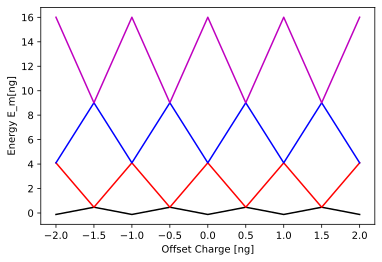

In [6]:
from qiskit_metal.analyses.hamiltonian.transmon_analytics import *
plot_eigenvalues() 

Next, we can easily calculate the transition energy between states using the Hcpb class. Here, we define values of $E_{J}$, $E_{C}$ and $n_g$ and then calculate transition frequency between the first and second states as well as the anharmonicity. Units:  all energies in units of MHz  (recall energy is ħω=hf)

In [7]:
H = Hcpb(nlevels=15, Ej=13971.3, Ec=295.2, ng=0.001)
print(f"""
Transmon frequencies 

 ω01/2π = {H.fij(0,1): 6.0f} MHz
   α/2π = {H.anharm(): 6.0f} MHz
""")



Transmon frequencies 

 ω01/2π =   5431 MHz
   α/2π =   -341 MHz



We can compare calculated eigenvalues with the analytic solutions by using the "Hcpb_analytic" class, which calculates the transmon eigenvalues analytically using Mathieu characteristic values instead of a matrix-based approach. Let's compare the calculated values of the lowest energy at zero offset charge in both cases:  

In [8]:
# this is using the Hcpb approach as above, solving the charge basis tridiagonal eigenvalue problem:
H_CPB = Hcpb(nlevels=15, Ej=13971.3, Ec=295.2, ng=0.0)

# this using the Hcpb_analytic class, which solves using the exact (analytic) solutions in terms of Mathieu characteristic values: 
H_CPB_analytic = Hcpb_analytic(Ej=13971.3, Ec=295.2, ng=0.0)

# print and compare energies 
print("E0 (HCPB):", H_CPB.evalue_k(0))
print("E0 (HCPB analytic):", H_CPB_analytic.evalue_k(0))
print("Error:", 100*(H_CPB_analytic.evalue_k(0) - H_CPB.evalue_k(0)) / H_CPB_analytic.evalue_k(0))


E0 (HCPB): -11175.114908534233
E0 (HCPB analytic): -11175.114908534231
Error: -1.6277142726798518e-14


As we can see above, the calculated eigenvalues using the Hcbp class match the analytic values extremely well. 

### Wavefunctions 

We can plot the eigenstates (wavefunctions) of the transmon qubit using the commands below: 

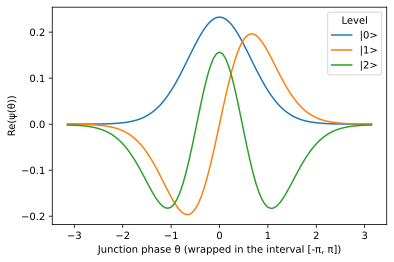

In [9]:
import matplotlib.pyplot as plt
for k in range (3):
    ψ, θ = H.psi_k(k,101)
    plt.plot(θ, ψ.real+ψ.imag, label=f"|{k}>") # it's in either quadrature, but not both
plt.xlabel("Junction phase θ (wrapped in the interval [-π, π])")
plt.ylabel("Re(ψ(θ))")
plt.legend(title="Level")

### Verifying Orthonormality of the Wavefunctions

Here, we can verify the orthonormality of the wavefunctions. Let's first take the first two eigenstates and verify that their inner product is zero, thereby confirming orthogonality. Note that since the wavefunctions can be complex, we need to take the complex conjugate of $\Psi1$. 

In [10]:
Psi0, theta0 = H.psi_k(0)
Psi1, theta1 = H.psi_k(1)
print(np.dot(Psi0,Psi1.conj()))

(-4.33541288806516e-12-1.8837350082088713e-17j)


Indeed, we see that the dot product is essentially zero (within numerical precision.) Next, let's take the inner product of the first eigenstate with itself, checking that we get an output of unity:

In [11]:
print(np.dot(Psi0, Psi0.conj()))
print(np.dot(Psi1, Psi1.conj()))

(0.9999999999999999+0j)
(0.9999999999999999+0j)


Indeed we see that the dot products are essentially equal to unity, confirming that the states are appropriately normalized.  

# Qutip simulation 

##### Diagonal Hamiltonian

Wrapper around Qutip to output the diagonalized
Hamiltonian truncated up to n levels of the transmon
for modeling

In [12]:
H.h0_to_qutip(6)

Quantum object: dims = [[6], [6]], shape = (6, 6), type = oper, isherm = True
Qobj data =
[[    0.             0.             0.             0.
      0.             0.        ]
 [    0.          5431.18890899     0.             0.
      0.             0.        ]
 [    0.             0.         10521.34965057     0.
      0.             0.        ]
 [    0.             0.             0.         15230.05309908
      0.             0.        ]
 [    0.             0.             0.             0.
  19411.29286922     0.        ]
 [    0.             0.             0.             0.
      0.         23436.04825632]]

##### Coupling and number operator
Wrapper around Qutip to output the number operator (charge)
for the Transmon Hamiltonian in the energy eigen-basis.
Used for computing the
coupling between other elements in the system.

In [13]:
H.n_to_qutip(6)

Quantum object: dims = [[6], [6]], shape = (6, 6), type = oper, isherm = True
Qobj data =
[[0.00000000e+00 1.07206033e+00 1.02976713e-07 4.02346313e-02
  1.38094462e-06 3.43263667e-03]
 [1.07206033e+00 0.00000000e+00 1.46700476e+00 3.55139515e-06
  8.85593881e-02 3.52050940e-05]
 [1.02976713e-07 1.46700476e+00 0.00000000e+00 1.72461929e+00
  6.22670448e-05 1.54709064e-01]
 [4.02346313e-02 3.55139515e-06 1.72461929e+00 0.00000000e+00
  1.88647000e+00 8.12857355e-04]
 [1.38094462e-06 8.85593881e-02 6.22670448e-05 1.88647000e+00
  0.00000000e+00 1.88284096e+00]
 [3.43263667e-03 3.52050940e-05 1.54709064e-01 8.12857355e-04
  1.88284096e+00 0.00000000e+00]]

# Experimental  

Let's use the "params_from_spectrum" function to calculate the target Ej and Ec values for a desired transmon frequency and anharmonicity. We'll use values of Ej=13971.3 MHz and Ec=295.2 MHz. 

In [14]:
# 13971.3, Ec=295.2
ω, α = 5431, -341
EjEc = H.params_from_spectrum(ω, α) # set self.Ej, Cj
print(EjEc)
print("transmon frequency:", H.fij(0,1), "anharmonicity:", H.anharm())


[13971.26315464   295.1788229 ]
transmon frequency: 5430.998460596111 anharmonicity: -341.001385546484


We can also calculate the value of Ej given the value of Ec and the transmon frequency:

In [ ]:
Ej = H.params_from_freq_fixEC(ω, 295.17)
print("Ej:", Ej)

We see that this is close to the starting vaue of 13971.3 MHz that we began with. 

# New section on integrating sc_qubits. 

This section is in development. 

In [ ]:
import scqubits as scq

In [ ]:
qubit = scq.Transmon(
    EJ=13.97124102543,
    EC=0.295179,
    ng=0.001,
    ncut=40,
    truncated_dim=4     # after diagonalization, we will keep 3 levels
)
evals = qubit.eigenvals(evals_count=12)
print(f"freq = {(evals[1] - evals[0])* 1000:.0f} MHz")
print(f"alpha = {((evals[2] - evals[1]) - (evals[1] - evals[0]))* 1000:.0f} MHz")

In [ ]:
qubit.plot_n_wavefunction()
qubit.plot_phi_wavefunction(which=[0,1,2], mode='real')
qubit.hamiltonian()

In [ ]:
import numpy as np
ng_list = np.linspace(-2, 2, 220)
qubit.plot_evals_vs_paramvals('ng', ng_list, evals_count=6, subtract_ground=False);

# Transmon and the Oscillator

This section is currently in development. 